# ING580 Course Project : Distance Geometry Method for Constructing Word Vectors

Team Members : junkai.xia@polytechnique.edu, tianyang.huang@polytechnique.edu

The implementation is based on the publicaition : https://www.researchgate.net/publication/341126429_A_New_Distance_Geometry_Method_for_Constructing_Word_and_Sentence_Vectors, more specifically Section 4 and 5.1.


In [1]:

import math
import os
import re
import string
from collections import Counter

import cvxpy as cp
import gensim
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
from amplpy import AMPL, add_to_path
from gensim.models.doc2vec import Doc2Vec
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA as sk_PCA
from torchtext.datasets import AG_NEWS

In [2]:
add_to_path("/home/hty/ampl_linux")

### Step 1: Load the text file, the `AG_news`, "cleans" it and split into sentences. 

We parse and clean the input text file using some basic NLTK functions. 
Specifically, we removed *Stop Words* and *Punctuations* in the sentences. 

--- 

### About the dataset `AG_news`: 

Introduced by Zhang et al. in Character-level Convolutional Networks for Text Classification, `AG News` (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. The `AG News` contains 30,000 training and 1,900 test samples per class.

More on the dataset: 
https://paperswithcode.com/dataset/ag-news

and it's implementation in python (pytorch):
https://pytorch.org/text/stable/datasets.html#ag-news

---

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/hty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# we list 10 of the most common stop words in English

stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [5]:
# Stemming: reducing inflected (or sometimes derived) words to their word stem, base or root form
ps = PorterStemmer()

In [6]:
# build tokens:  convert words to lower case and there base form
# This steps takes about 2 mins !!

train_dataset, test_dataset = AG_NEWS()  # the training set, size 120000
train_iter = iter(train_dataset)
test_iter = iter(test_dataset)

def tokenize(line):
    res = []
    raw = [ps.stem(w.lower()) for w in line.split() if
           (w.lower() not in stopwords and re.match(u'[a-z]', w, flags=re.I))]
    for item in raw:
        if "\\" in item:
            res += [ps.stem(w.lower()) for w in item.split("\\")]
        else:
            res.append(item)
    return res


In [7]:

tokens = []
for label, line in train_dataset:
    tokens += tokenize(line)

In [8]:
# Some statistics about the tokens: we list here the 5 most common token in the training set along with their number of occurrence. 
cnt_tokens = Counter(tokens)
cnt_tokens.most_common()[:5]

[('new', 21118),
 ('said', 16855),
 ('us', 12148),
 ('first', 8956),
 ('two', 8882)]

In [9]:

from torchtext.data import to_map_style_dataset

train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)
len(train_dataset), len(test_dataset)

(120000, 7600)

In [10]:
count = [0,0,0,0]
for id, (label, text) in enumerate(train_dataset):
    count[label-1] += 1
    if id > 1200:
        break

In [11]:
count

[273, 182, 202, 545]

In [12]:
def build_documents(size=10):
    docs = []
    for i in range(size):
        docs.append(next(test_iter)[1])
    return docs

In [82]:
# Documents containing several sentences
# the docs variable is a list of sentences, its length = size. 
docs = build_documents(size=20)
docs[9]  # sample the last sentence in docs.

'Suspect charged in abduction, sexual assault of 11-year-old girl (Canadian Press) Canadian Press - LANGLEY, B.C. (CP) - Police have arrested a man in the kidnapping and sexual assault of an 11-year-old girl that frightened this suburban Vancouver community last week.'

In [113]:
docs.append("This is a famous NLP semantic test. The Lazy dog was jumped over by the quick brown fox.")
docs.append("This is a famous NLP semantic test. The quick brown fox was jumped over by the Lazy dog.")
docs.append("This is a famous NLP semantic test. The Lazy fox was jumped over by the quick brown dog.")
docs.append("This is a famous NLP semantic test. The quick brown dog was jumped over by the Lazy fox.")

### Step 2: Construct a Graph-of-words from each sentence. 

Given a sentence `s` represented as a sequence of words $s = (s_1, s_2, .., s_m)$, an *n_gram* is a subsequent of n consecutive words of `s`. Thus each sentence has at most $(m-n+1)$ n-grams. In a graph-of-words $G = (V, E)$ of order $n, V$ is the set of words in `s`, i.e. each unique word in `s` is associated to a single vertex, even if the same word appears more than once in `s`. Two words have an edge **only if they appear in the same n-gram**. The weight of the edge is equal to the number of n-grams in which the two words appear.

### Step 3: Map graph-of-words to realization (word vectors), using Distance Geometry method.
See the `solve_dgp` function

### Step 4: Stack word vectors onto single sentence vectors
(i.e. it concatenates the rows of a realization) and zero-pads the shorter vectors to fit all vectors to a same size, yielding sentence vectors

### Step 5: Shorten the sentence vectors using dimensional reduction
See the `stack` function

In [114]:
## utility functions

def remove_iso(mat):
    dim = mat.shape[0]
    d = []
    for z in range(dim):  # loop on rows
        if mat[z, 0] == np.inf:
            d.append(z)
    mat = np.delete(mat, d, axis=0)
    mat = np.delete(mat, d, axis=1)
    return mat


def dist2Gram(D):
    # Distance matrix to Gram matrix
    n = D.shape[0]
    J = np.identity(n) - (1.0 / n) * np.ones((n, n))
    G = -0.5 * J @ (D @ (D @ J))
    return G

In [115]:
def writeRlz(graph, n, rlzfn):
    """
    
    # write realization to file

    graph : GOW
    n : total number of nodes in the graph
    rlzfn : realization file name 
    """
    Kdim = 10
    rlz = open(rlzfn, "w")
    print("param Kdim := "+str(Kdim)+";", file=rlz)
    print("param n := " + str(graph.number_of_nodes()) + ";", file=rlz)
    print("param : E : c I :=", file=rlz)
    for i in range(n):
        wi = list(graph.nodes)[i]
        for k in range(i + 1, n):
            wk = list(graph.nodes)[k]
            if graph.has_edge(wi, wk):
                print(str(i + 1) + " " + str(k + 1) + " " + str(graph.get_edge_data(wi, wk)["weight"]) + " " + str(1),
                      file=rlz)
    print(";", file=rlz)
    rlz.close()
    return


def readDat(filename):
    # read data from file

    edgeflag = False  # true while reading edges
    Kdim = 10
    n = 0
    E = list()
    linecount = 0
    with open(filename) as f:
        for line in f:
            # look at file line by line
            line = line.strip()
            linecount += 1
            if len(line) > 0:
                if line[0] != '#':
                    # line non-empty and non-comment
                    if edgeflag:
                        if line[0] == ';':
                            # if only a ';' then we're closing the edge section
                            edgeflag = False
                        else:
                            # reading uncommented edge data
                            cols = [c for c in line.split() if not '#' in c]
                            #                             print(cols)
                            if len(cols) >= 6:
                                e = (int(cols[0]), int(cols[1]), float(cols[4]), float(cols[5]))
                            elif len(cols) >= 4:
                                e = (int(cols[0]), int(cols[1]), float(cols[2]), float(cols[2]))
                                if e[2] > e[3]:
                                    print("readDat: WARNING: interval weight[", e[2], ",", e[3], "] empty, setting to",
                                          e[2])
                                    e[3] = e[2]
                            else:
                                print("readDat: ERROR: line", linecount, "has < 4 columns")
                                exit('abort')
                            E.append(e)
                    else:
                        if line.replace(" ", "")[0:7] == 'param:E':
                            # we're in the edge section now
                            edgeflag = True
                        elif line.replace(" ", "")[0:9] == 'paramKdim':
                            # parse line defining Kdim
                            Kdimstr = line.split()[3]
                            if Kdimstr[-1] == ';':
                                Kdimstr = Kdimstr[0:-1]
                            Kdim = int(Kdimstr)
                        elif line.replace(" ", "")[0:6] == 'paramn':
                            # parse line defining n
                            nstr = line.split()[3]
                            if nstr[-1] == ';':
                                nstr = nstr[0:-1]
                            n = int(nstr)
    return (Kdim, n, E)

#### The `Graph of words` class

In [116]:
from time import time
def timer_func(func):
    # This function shows the execution time of
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [117]:
from tqdm import tqdm_notebook

class Graph_of_words():

    def __init__(self, documents, Kdim = 10):
        self.documents = documents  # D : list of sentences [sentence1，sentence2，...]
        self.stopwords = nltk.corpus.stopwords.words('english') + [string.punctuation]
        self.tokens = []  # token of the corresponding document
        self.dictionary = []  # set of all the words of the whole document, aka Vocabulary
        self.n = None  # number of words of the whole doc = len(dictionary), Vocab size
        self.m = len(self.documents)  # num of sentences
        self.length = 0  # num of nodes of the longest sentence, useful for padding
        self.graphs = []  # one graph for each sentence
        self.word_vec = []  # set of the word vectors of each sentence
        self.coords = []  # (euclidean) realization
        self.Kdim = Kdim  # dimension needed, K = 10 in the article.

    @timer_func
    def preprocessing(self):
        # tokenize, build dictionary
        # it reads a text file, “cleans” it, and splits it into sentences
        for sentence in self.documents:
            t_temp = tokenize(sentence)
            self.tokens.append(t_temp)
            self.length += len(t_temp)
            self.dictionary += [ps.stem(w.lower()) for w in sentence.split() if
                                (w.lower() not in self.stopwords and re.match(u'[a-z]', w, flags=re.I))]

        self.dictionary = list(set(self.dictionary))
        self.n = len(self.dictionary)
        self.idf = np.zeros((self.n, 1))
        self.tw_idf = np.zeros((self.n, self.m))

        # distance matrix of each sentence given by the graph of word
        self.metric = []

    # build graph
    def update_graph_init(self, window, g):
        n = len(window)
        for i in range(n):
            for j in range(i + 1, n):
                if not g.has_edge(window[i], window[j]):
                    g.add_edge(window[i], window[j], weight=1)
                else:
                    g[window[i]][window[j]]["weight"] += 1

    def update_graph(self, window, g):
        n = len(window)
        for i in range(n - 1):
            if not g.has_edge(window[i], window[n - 1]):
                g.add_edge(window[i], window[n - 1], weight=1)
            else:
                # The weight of the edge is equal to the number of n-grams in which the two words appear
                g[window[i]][window[n - 1]]["weight"] += 1

    @timer_func
    def graph_construction(self, window_size=5):
        #  constructs a graph-of-words (Sect. 4.2) from each sentence
        max_length = 0
        for idx, doc in enumerate(self.documents):
            t_temp = self.tokens[idx]
            g_temp = nx.Graph()
            for t in self.dictionary:
                if t in t_temp:
                    # each unique word in s is associated to a single vertex
                    g_temp.add_node(t)

            if len(t_temp) < window_size:
                g_temp.add_edge(t_temp[0], t_temp[1], weight=1)

            # Two words have an edge only if they appear in the same n-gram
            windows = t_temp[0:window_size]
            self.update_graph_init(windows, g_temp)
            for i in range(len(t_temp) - window_size):
                windows.pop(0)
                windows.append(t_temp[window_size + i])
                self.update_graph(windows, g_temp)

            self.graphs.append(g_temp)
            max_length = max(max_length, g_temp.number_of_nodes())

        self.length = max_length

    def graph_construction_corpus(self, window_size=3):

        #  constructs a graph-of-words (Sect. 4.2) from each sentence
        max_length = 0
        g_temp = nx.Graph()

        for idx, doc in tqdm_notebook(enumerate(self.documents)):
            t_temp = self.tokens[idx] # tokens of the document
            for t in self.dictionary:
                if t in t_temp:
                    g_temp.add_node(t)

            if len(t_temp) < window_size:
                g_temp.add_edge(t_temp[0], t_temp[1], weight=1)

            # Two words have an edge only if they appear in the same n-gram
            windows = t_temp[0:window_size]
            self.update_graph_init(windows, g_temp)
            for i in range(len(t_temp) - window_size):
                windows.pop(0)
                windows.append(t_temp[window_size + i])
                self.update_graph(windows, g_temp)


            max_length = max(max_length, g_temp.number_of_nodes())

        self.graphs.append(g_temp)
        self.length = max_length


    # graph properties
    #
    #     def degree_centrality(node,g):
    #         if not node in gg.nodes:
    #             return 0
    #         neighbors=[i for i in nx.neighbors(g,node)]
    #         return len(neighbors)/g.number_of_nodes()

    #     def term_weighting(self,b=0.003):
    #         for i in range(self.n):
    #             word=self.dictionnary[i]
    #             self.idf[i,0]=np.log((self.m+1)/len([d for d in self.documents if re.search(word, d, flags=re.I)]))
    #         for i in range(self.n):
    #             word=self.dictionnary[i]
    #             for j in range(self.m):
    #                 token_temp=self.tokens[j]
    #                 g_temp=self.graphs[j]
    #                 cbt_temp=Counter(token_temp)
    #                 tf=cbt_temp[word]
    #                 self.tw_idf[i,j]=self.idf[i,0]*(Graph_of_words.degree_centrality(word,g_temp))/(1-b+b*len(token_temp)/(self.length/self.m))

    def write_dat(self):
        for i in range(self.m):
            graph = self.graphs[i]
            file_name = "./data/sentence_" + str(i) + ".dat"
            writeRlz(graph, graph.number_of_nodes(), file_name)

    # uses DG methods to map graphs-of-words to realizations
    def _solve_dgp(self, idx, filename):
        self.Kdim, n, E = readDat(filename)
        print("graph read")
        g_temp = self.graphs[idx]
        K = g_temp.number_of_nodes()
        G = {i: dict() for i in range(n)}

        for e in E:
            i = e[0] - 1  # first vertex
            j = e[1] - 1  # second vertex
            w = e[2]  # edge weight
            if i > j:
                t = i
                i = j
                j = t
            G[i][j] = w

        X = cp.Variable((n, n), PSD=True)
        S = cp.Variable((n, n))
        cobj1 = sum([X[i, i] + X[j, j] - 2 * X[i, j] for i in range(n) for j in G[i] if i < j])
        cobj2 = cp.trace(X)

        # different criteria
        #         R = 2*np.random.rand(n,n) - 1
        #         cobj3 = cp.trace(R@X)
        cobj4 = sum([S[i, j] ** 2 for i in range(n) for j in range(n)])
        cobj = cobj1 + 0.1 * cobj2 + cobj4  # + 0.1*cobj3

        objective = cp.Minimize(cobj)
        constraints = [X[i, i] + X[j, j] - 2 * X[i, j] == G[i][j] ** 2 + S[i, j] for i in range(n) for j in G[i] if
                       i < j]
        prob = cp.Problem(objective, constraints)
        print("problem set")
        prob.solve(solver=cp.SCS, verbose=True)
        xbar = Barvinok(X.value, K)

        print("start nlp")

        nlp = AMPL()
        nlp.read("dgp.mod")
        nlp.readData(filename)
        nlp.setOption('solver', NLPsolver)
        xvar = nlp.getVariable('x')

        for i in range(n):
            for k in range(self.Kdim):
                xvar[i + 1, k + 1].setValue(xbar[i, k])
        nlp.solve()
        xvar = nlp.getVariable('x')
        xval = xvar.getValues()
        x = np.zeros((n, self.Kdim))
        for i in range(n):
            for k in range(self.Kdim):
                x[i, k] = xvar[i + 1, k + 1].value()

        self.word_vec.append(x)

    def solve_dgp(self):
        for i in tqdm_notebook(range(self.m)):
            file_name = "./data/sentence_" + str(i) + ".dat"
            self._solve_dgp(i, file_name)

    def solve_dgp_corpus(self, filename):
        self._solve_dgp(0, filename)


    # stacks these realizations onto single vectors (i.e. it concatenates the rows of a realization) and
    # zero-pads the shorter vectors to fit all vectors to a same size, yielding sentence vectors
    def _stacks(self, list_word_vec):
        avg = np.mean(list_word_vec, axis=0)
        if len(avg) > self.length:
            return avg[:self.length]
        else:
            return np.pad(avg, (0, self.length - len(avg)))

    # shortens the sentence vectors using dimensional reduction
    def stack(self, k=10):
        total_vec = np.zeros((self.m, self.length))
        pca = sk_PCA(n_components=k)

        for i in range(self.m):
            sentence_vec = self._stacks(self.word_vec[i])
            total_vec[i] = sentence_vec

        self.coords = pca.fit_transform(total_vec)


In [118]:
LPsolver = "cplex"
NLPsolver = "ipopt"
projmethod = "Barvinok"
# projmethod = "PCA"

In [119]:
def factor(A):
    n = A.shape[0]
    (evals, evecs) = np.linalg.eigh(A)
    evals[evals < 0] = 0  # closest SDP matrix
    X = evecs
    sqrootdiag = np.eye(n)
    for i in range(n):
        sqrootdiag[i, i] = np.sqrt(evals[i])
    X = X.dot(sqrootdiag)
    # because default eig order is small->large
    return np.fliplr(X)


def PCA(B, K):
    x = factor(B)
    # only first K columns
    x = x[:, 0:K]
    return x


def Barvinok(B, K):
    n = B.shape[0]
    X = factor(B)
    y = (1 / math.sqrt(K)) * np.random.multivariate_normal(np.zeros(n * K), np.identity(n * K))
    y = np.reshape(y, (K, n))
    x = np.transpose(np.dot(y, X.T))
    return x

In [120]:
G = Graph_of_words(docs)
G.preprocessing()
G.dictionary[:5]

Function 'preprocessing' executed in 0.0169s


['calif.', 'app', 'event,', "scientists'", 'kidnap']

In [121]:
# G.graph_construction_corpus()
start_time = time()
graph = G.graphs[0]
file_name = "./data/corpus_12.dat"
writeRlz(graph, graph.number_of_nodes(), file_name)
print(time()-start_time)

IndexError: list index out of range

In [122]:
G.graph_construction()
G.write_dat()
G.graphs[0].edges.data()

Function 'graph_construction' executed in 0.0042s


EdgeDataView([('stewart', 'announc', {'weight': 1}), ('stewart', 'select', {'weight': 1}), ('stewart', 'jay', {'weight': 1}), ('stewart', 'haa', {'weight': 1}), ('stewart', 'cink', {'weight': 1}), ('stewart', "captain'", {'weight': 1}), ('stewart', 'picks.', {'weight': 1}), ('network)', 'ryder', {'weight': 2}), ('network)', 'cup', {'weight': 2}), ('network)', 'team', {'weight': 1}), ('network)', 'milwauke', {'weight': 1}), ('network)', 'u.s.', {'weight': 1}), ('network)', 'captain', {'weight': 1}), ('final', 'cup', {'weight': 1}), ('final', 'captain', {'weight': 1}), ('final', 'hal', {'weight': 1}), ('final', 'sutton', {'weight': 1}), ('final', 'team', {'weight': 1}), ('final', 'monday', {'weight': 1}), ('final', 'announc', {'weight': 1}), ('final', 'select', {'weight': 1}), ('u.s.', 'cup', {'weight': 2}), ('u.s.', 'team', {'weight': 1}), ('u.s.', 'milwauke', {'weight': 1}), ('u.s.', 'ryder', {'weight': 1}), ('u.s.', 'captain', {'weight': 1}), ('u.s.', 'hal', {'weight': 1}), ('select',

In [123]:
# G.solve_dgp_corpus("./data/corpus_12.dat")

In [124]:
G.solve_dgp()
G.stack() 

/tmp/ipykernel_7922/3156123891.py:200: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(self.m)):


  0%|          | 0/26 [00:00<?, ?it/s]

graph read
problem set
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 20 11:04:30 PM: Your problem has 882 variables, 86 constraints, and 0 parameters.
(CVXPY) Mar 20 11:04:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 20 11:04:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 20 11:04:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 20 11:04:30 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 20 11:04:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

### Result Explorations

In [125]:
G.coords


array([[-1.66882530e-06, -5.25937899e-07, -1.99559344e-06,
        -3.31005017e-06, -2.23025554e-07, -1.98781123e-07,
        -6.22827646e-07, -2.26699733e-07,  1.35850010e-07,
        -2.01320117e-07],
       [-3.38626857e-06,  7.78451850e-07, -2.72147769e-06,
        -3.82054390e-06, -1.79652350e-08, -1.67432842e-06,
         4.69438491e-06, -1.48812823e-08, -9.40311570e-07,
        -9.05291990e-07],
       [-6.41718157e-06, -3.45349882e-06, -1.98571540e-07,
         2.56640508e-06, -1.84542620e-06,  1.19745120e-05,
         4.48631280e-07,  4.26204416e-06,  1.41965981e-07,
        -3.55872707e-08],
       [-1.65260047e-06, -4.85064107e-07, -1.99750807e-06,
        -3.28420598e-06, -2.96796554e-07, -1.93342409e-07,
        -5.81483817e-07, -1.76393517e-07,  1.81906162e-07,
        -1.65855831e-07],
       [-6.29721186e-06,  8.75441344e-06,  6.75816254e-06,
         3.49438584e-06,  1.77694339e-05, -1.70119038e-06,
        -2.05549206e-06,  1.20730796e-06, -8.99297059e-07,
        -4.

In [126]:
# np.save("Realization_2400_30_test", G.coords)

In [127]:
G.coords.shape

(26, 10)

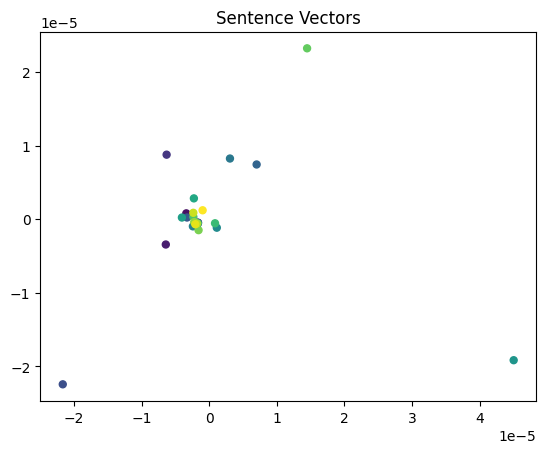

In [128]:
plt.figure()
plt.scatter(G.coords[:, 0], G.coords[:, 1], s=100, c=np.arange(len(G.coords)), marker=".")
# plt.legend()
plt.title("Sentence Vectors")
plt.show()

In [129]:
sentence_vector1 = G.coords[-1]
sentence_vector2 = G.coords[-2]

In [130]:
def cosine_sim(v1, v2):
    return v1 @ v2 /np.linalg.norm(v1) /np.linalg.norm(v2)

for v in G.coords:
    print(cosine_sim(v, sentence_vector1))

0.8413513322922918
0.53771886711457
-0.20639265833509263
0.8380342151651547
0.07322491796318904
0.8379536044972029
-0.3563363244026138
0.6525649077770361
-0.43214998104365926
0.8177592594154752
-0.3033404981859878
0.6941642865863756
-0.2925312715361388
-0.300176387243409
0.06931512236853628
-0.6583542751165057
0.834101229360598
0.5969164311263253
0.8377213462475216
-0.05731007746651715
0.7513536025713013
0.6738563856829451
0.5512063030414361
0.8208366853542821
0.8298161506087439
1.0000000000000002


In [134]:
matrix = np.zeros((4,4))
for iv, v in enumerate(G.coords[-4:]):
    for iu, u in enumerate(G.coords[-4:]):
        matrix[iv][iu] = cosine_sim(v, u)
print(docs[-4])
print(docs[-3])
print(docs[-2])
print(docs[-1])
print(matrix)

This is a famous NLP semantic test. The Lazy dog was jumped over by the quick brown fox.
This is a famous NLP semantic test. The quick brown fox was jumped over by the Lazy dog.
This is a famous NLP semantic test. The Lazy fox was jumped over by the quick brown dog.
This is a famous NLP semantic test. The quick brown dog was jumped over by the Lazy fox.
[[1.         0.75352646 0.67716044 0.5512063 ]
 [0.75352646 1.         0.74241533 0.82083669]
 [0.67716044 0.74241533 1.         0.82981615]
 [0.5512063  0.82083669 0.82981615 1.        ]]


### Step 7: Classification

This dataset contains reviews of hotels, we would like to predict whether each of them is positive or negative

In [ ]:
def get_text(file):
    data_text = pd.read_table(file)
    return data_text

In [ ]:
path_text_dataset = 'reviews_data.txt'
text_dataset = get_text(path_text_dataset).values
text_dataset = [item[-2] for item in text_dataset]
len(text_dataset), text_dataset[:2]

In [ ]:
TaggedDocument = gensim.models.doc2vec.TaggedDocument

In [ ]:
def X_text(sentences):
    X = []
    for i, text in enumerate(sentences):
        if not isinstance(text, str):
            continue
        words = text.split(" ")
        l = len(words)
        words = words[:-2]
        document = TaggedDocument(words, tags=[i])
        X.append(document)
    return X

In [ ]:
X_documents = X_text(text_dataset)
len(X_documents), X_documents[:3]

In [ ]:
def train_text(text_train, size=100, epochs=10):
    """ doc2vec model provided by gensim """
    model = Doc2Vec(text_train, min_count=1, window=3, vector_size=size, sample=1e-3, negative=5, epochs=epochs)
    model.train(text_train, total_examples=model.corpus_count, epochs=model.epochs)
    return model

In [ ]:
model_text = train_text(X_documents)
if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')
model_text.save('WE_models/d2v_100D')

In [ ]:
model_text = Doc2Vec.load('WE_models/d2v_100D')

In [ ]:
def text2vec(text_train, alpha=0.05, min_alpha=0.025, epochs=10):
    list_text = []
    for sentence in text_train:
        words = sentence.split(" ")
        vec = model_text.infer_vector(doc_words=words, alpha=alpha, min_alpha=min_alpha, epochs=epochs).tolist()
        list_text.append(vec)
    return np.array(list_text)

In [ ]:
X_train_text_vec = text2vec(docs, alpha=0.05, min_alpha=0.025, epochs=10)
X_train_text_vec.shape

In [ ]:
pca = sk_PCA(n_components=2)

gensim_coords = pca.fit_transform(X_train_text_vec)
gensim_coords

In [ ]:
plt.figure()
plt.scatter(gensim_coords[:, 0], gensim_coords[:, 1], s=500, c=np.arange(len(gensim_coords)), marker="*",
            label=np.arange(len(gensim_coords)))
plt.legend()
plt.show()